(weibull_aft)=

# Reparameterizing the Weibull Accelerated Failure Time Model

:::{post} January 17, 2023
:tags: censored, survival analysis, weibull
:category: intermediate, how-to
:author: Junpeng Lao, George Ho, Chris Fonnesbeck
:::

In [1]:
import arviz.preview as az
import numpy as np
import pymc as pm
import pytensor.tensor as pt

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.27.1


:::{include} ../extra_installs.md
:::

In [2]:
# These dependencies need to be installed separately from PyMC
import statsmodels.api as sm

In [3]:
%config InlineBackend.figure_format = 'retina'
# These seeds are for sampling data observations
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
# Set a seed for reproducibility of posterior results
seed: int = sum(map(ord, "aft_weibull"))
rng: np.random.Generator = np.random.default_rng(seed=seed)
az.style.use("arviz-variat")

## Dataset

The {ref}`previous example notebook on Bayesian parametric survival analysis <bayes_param_survival_pymc3>` introduced two different accelerated failure time (AFT) models: Weibull and log-linear. In this notebook, we present three different parameterizations of the Weibull AFT model.

The data set we'll use is the `flchain` R data set, which comes from a medical study investigating the effect of serum free light chain (FLC) on lifespan. Read the full documentation of the data by running:

`print(sm.datasets.get_rdataset(package='survival', dataname='flchain').__doc__)`.

In [4]:
# Fetch and clean data
data = (
    sm.datasets.get_rdataset(package="survival", dataname="flchain")
    .data.sample(500)  # Limit ourselves to 500 observations
    .reset_index(drop=True)
)

In [5]:
y = data.futime.values
censored = ~data["death"].values.astype(bool)

In [6]:
y[:5]

array([ 975, 2272,  138, 4262, 4928])

In [7]:
censored[:5]

array([False,  True, False,  True,  True])

## Using `pm.Potential`

We have an unique problem when modelling censored data. Strictly speaking, we don't have any _data_ for censored values: we only know the _number_ of values that were censored. How can we include this information in our model?

One way do this is by making use of `pm.Potential`. The [PyMC2 docs](https://pymc-devs.github.io/pymc/modelbuilding.html#the-potential-class) explain its usage very well. Essentially, declaring `pm.Potential('x', logp)` will add `logp` to the log-likelihood of the model. 

However, `pm.Potential` only effect probability based sampling this excludes using `pm.sample_prior_predictice` and `pm.sample_posterior_predictive`. We can overcome these limitations by using `pm.Censored` instead. We can model our right-censored data by defining the `upper` argument of `pm.Censored`.

## Parameterization 1

This parameterization is an intuitive, straightforward parameterization of the Weibull survival function. This is probably the first parameterization to come to one's mind.

In [8]:
# normalize the event time between 0 and 1
y_norm = y / np.max(y)

In [9]:
# If censored then observed event time else maximum time
right_censored = [x if x > 0 else np.max(y_norm) for x in y_norm * censored]

In [10]:
with pm.Model() as model_1:
    alpha_sd = 1.0

    mu = pm.Normal("mu", mu=0, sigma=1)
    alpha_raw = pm.Normal("a0", mu=0, sigma=0.1)
    alpha = pm.Deterministic("alpha", pt.exp(alpha_sd * alpha_raw))
    beta = pm.Deterministic("beta", pt.exp(mu / alpha))
    beta_backtransformed = pm.Deterministic("beta_backtransformed", beta * np.max(y))

    latent = pm.Weibull.dist(alpha=alpha, beta=beta)
    y_obs = pm.Censored("Censored_likelihood", latent, upper=right_censored, observed=y_norm)

In [11]:
with model_1:
    idata_param1 = pm.sample(nuts_sampler="numpyro", random_seed=rng)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

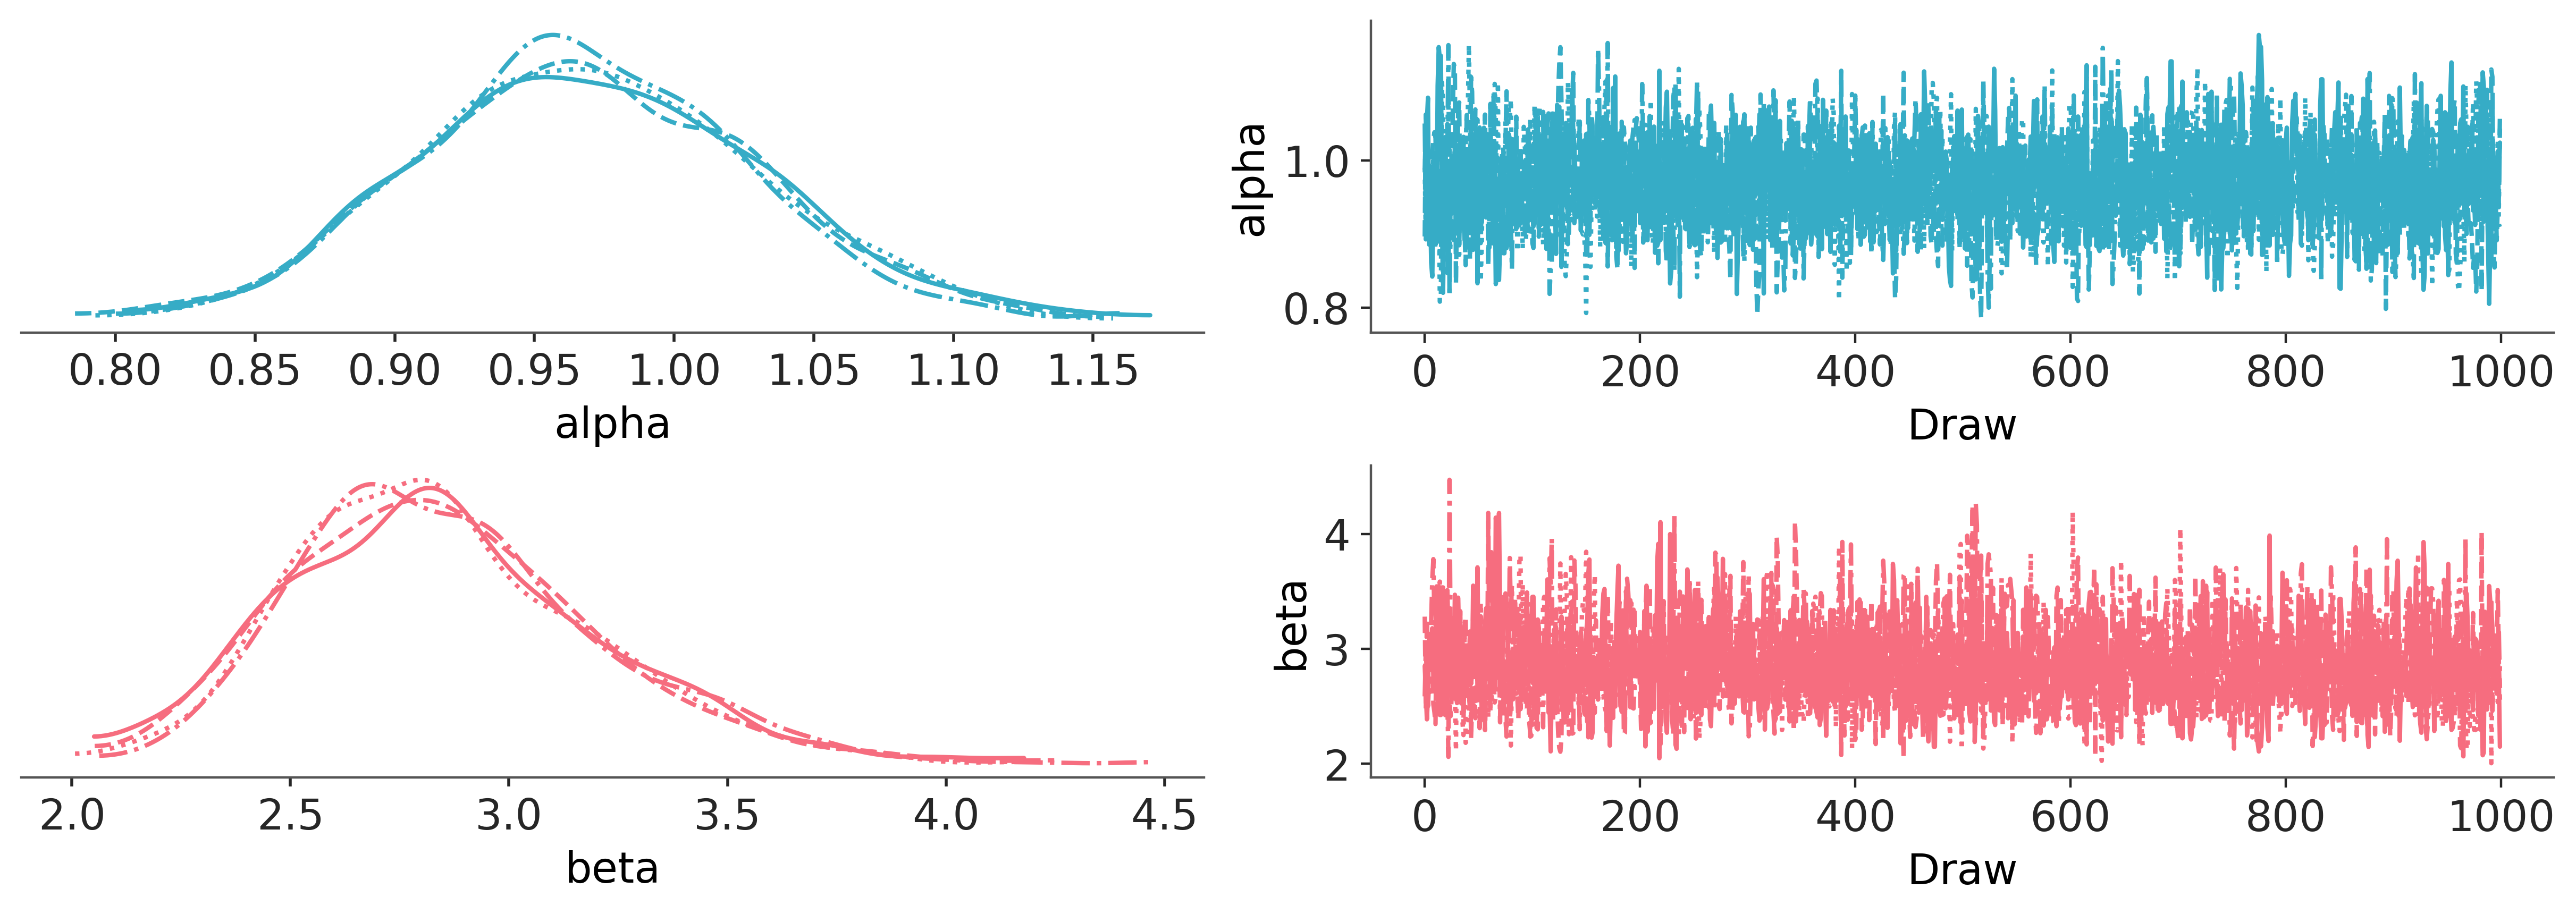

In [12]:
az.plot_trace_dist(idata_param1, var_names=["alpha", "beta"])

In [13]:
az.summary(idata_param1, var_names=["alpha", "beta", "beta_backtransformed"], round_to=2)

,mean,sd,eti89_lb,eti89_ub,ess_bulk,ess_tail,r_hat,mcse_mean,mcse_sd
alpha,0.97,0.06,0.88,1.07,2922.25,2486.55,1.0,0.00,0.00
beta,2.85,0.35,2.36,3.47,2409.49,2301.02,1.0,0.01,0.01
beta_backtransformed,14647.00,1799.50,12103.64,17806.81,2409.49,2301.02,1.0,36.29,28.44


## Parameterization 2

Note that, confusingly, `alpha` is now called `r`, and `alpha` denotes a prior; we maintain this notation to stay faithful to the original implementation in Stan. In this parameterization, we still model the same parameters `alpha` (now `r`) and `beta`.

For more information, see [this Stan example model](https://github.com/stan-dev/example-models/blob/5e9c5055dcea78ad756a6fb9b3ff9a77a0a4c22b/bugs_examples/vol1/kidney/kidney.stan) and [the corresponding documentation](https://www.mrc-bsu.cam.ac.uk/wp-content/uploads/WinBUGS_Vol1.pdf).

In [14]:
with pm.Model() as model_2:
    alpha = pm.Normal("alpha", mu=0, sigma=1)
    r = pm.Gamma("r", alpha=2, beta=1)
    beta = pm.Deterministic("beta", pt.exp(-alpha / r))
    beta_backtransformed = pm.Deterministic("beta_backtransformed", beta * np.max(y))

    latent = pm.Weibull.dist(alpha=r, beta=beta)
    y_obs = pm.Censored("Censored_likelihood", latent, upper=right_censored, observed=y_norm)

In [15]:
with model_2:
    idata_param2 = pm.sample(nuts_sampler="numpyro", random_seed=rng)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

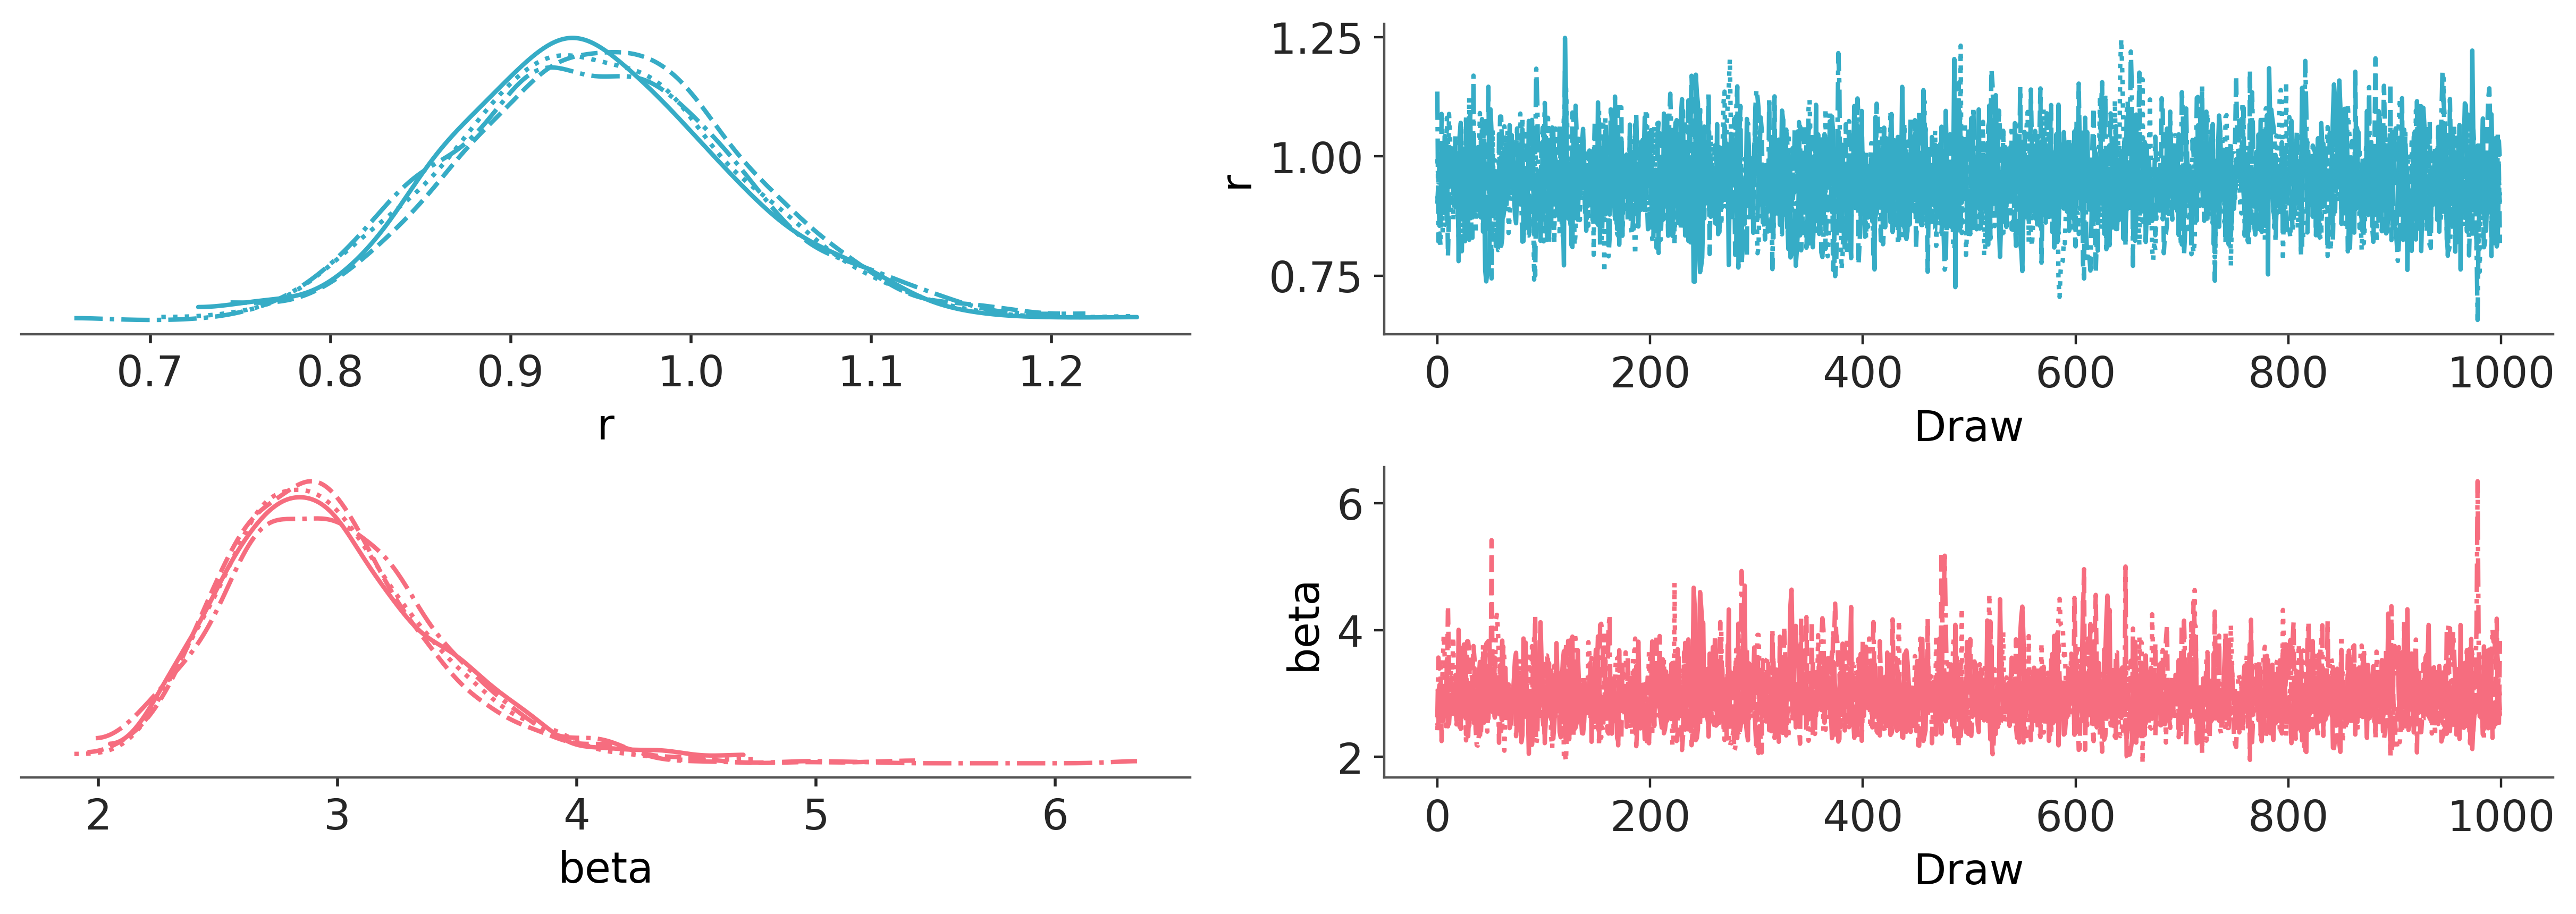

In [16]:
az.plot_trace_dist(idata_param2, var_names=["r", "beta"])

In [17]:
az.summary(idata_param2, var_names=["r", "beta", "beta_backtransformed"], round_to=2)

,mean,sd,eti89_lb,eti89_ub,ess_bulk,ess_tail,r_hat,mcse_mean,mcse_sd
r,0.95,0.08,0.83,1.08,2606.64,2352.91,1.0,0.00,0.00
beta,2.97,0.45,2.35,3.75,2266.62,2102.06,1.0,0.01,0.01
beta_backtransformed,15252.76,2290.22,12065.01,19230.23,2266.62,2102.06,1.0,49.10,48.46


## Parameterization 3

In this parameterization, we model the log-linear error distribution with a Gumbel distribution instead of modelling the survival function directly. For more information, see [this blog post](http://austinrochford.com/posts/2017-10-02-bayes-param-survival.html).

In [18]:
logtime = np.log(y)

In [19]:
# If censored then observed event time else maximum time
right_censored = [x if x > 0 else np.max(logtime) for x in logtime * censored]

In [20]:
with pm.Model() as model_3:
    s = pm.HalfNormal("s", tau=3.0)
    gamma = pm.Normal("gamma", mu=0, sigma=5)

    latent = pm.Gumbel.dist(mu=gamma, beta=s)
    y_obs = pm.Censored("Censored_likelihood", latent, upper=right_censored, observed=logtime)

In [21]:
with model_3:
    idata_param3 = pm.sample(tune=4000, draws=2000, nuts_sampler="numpyro", random_seed=rng)

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

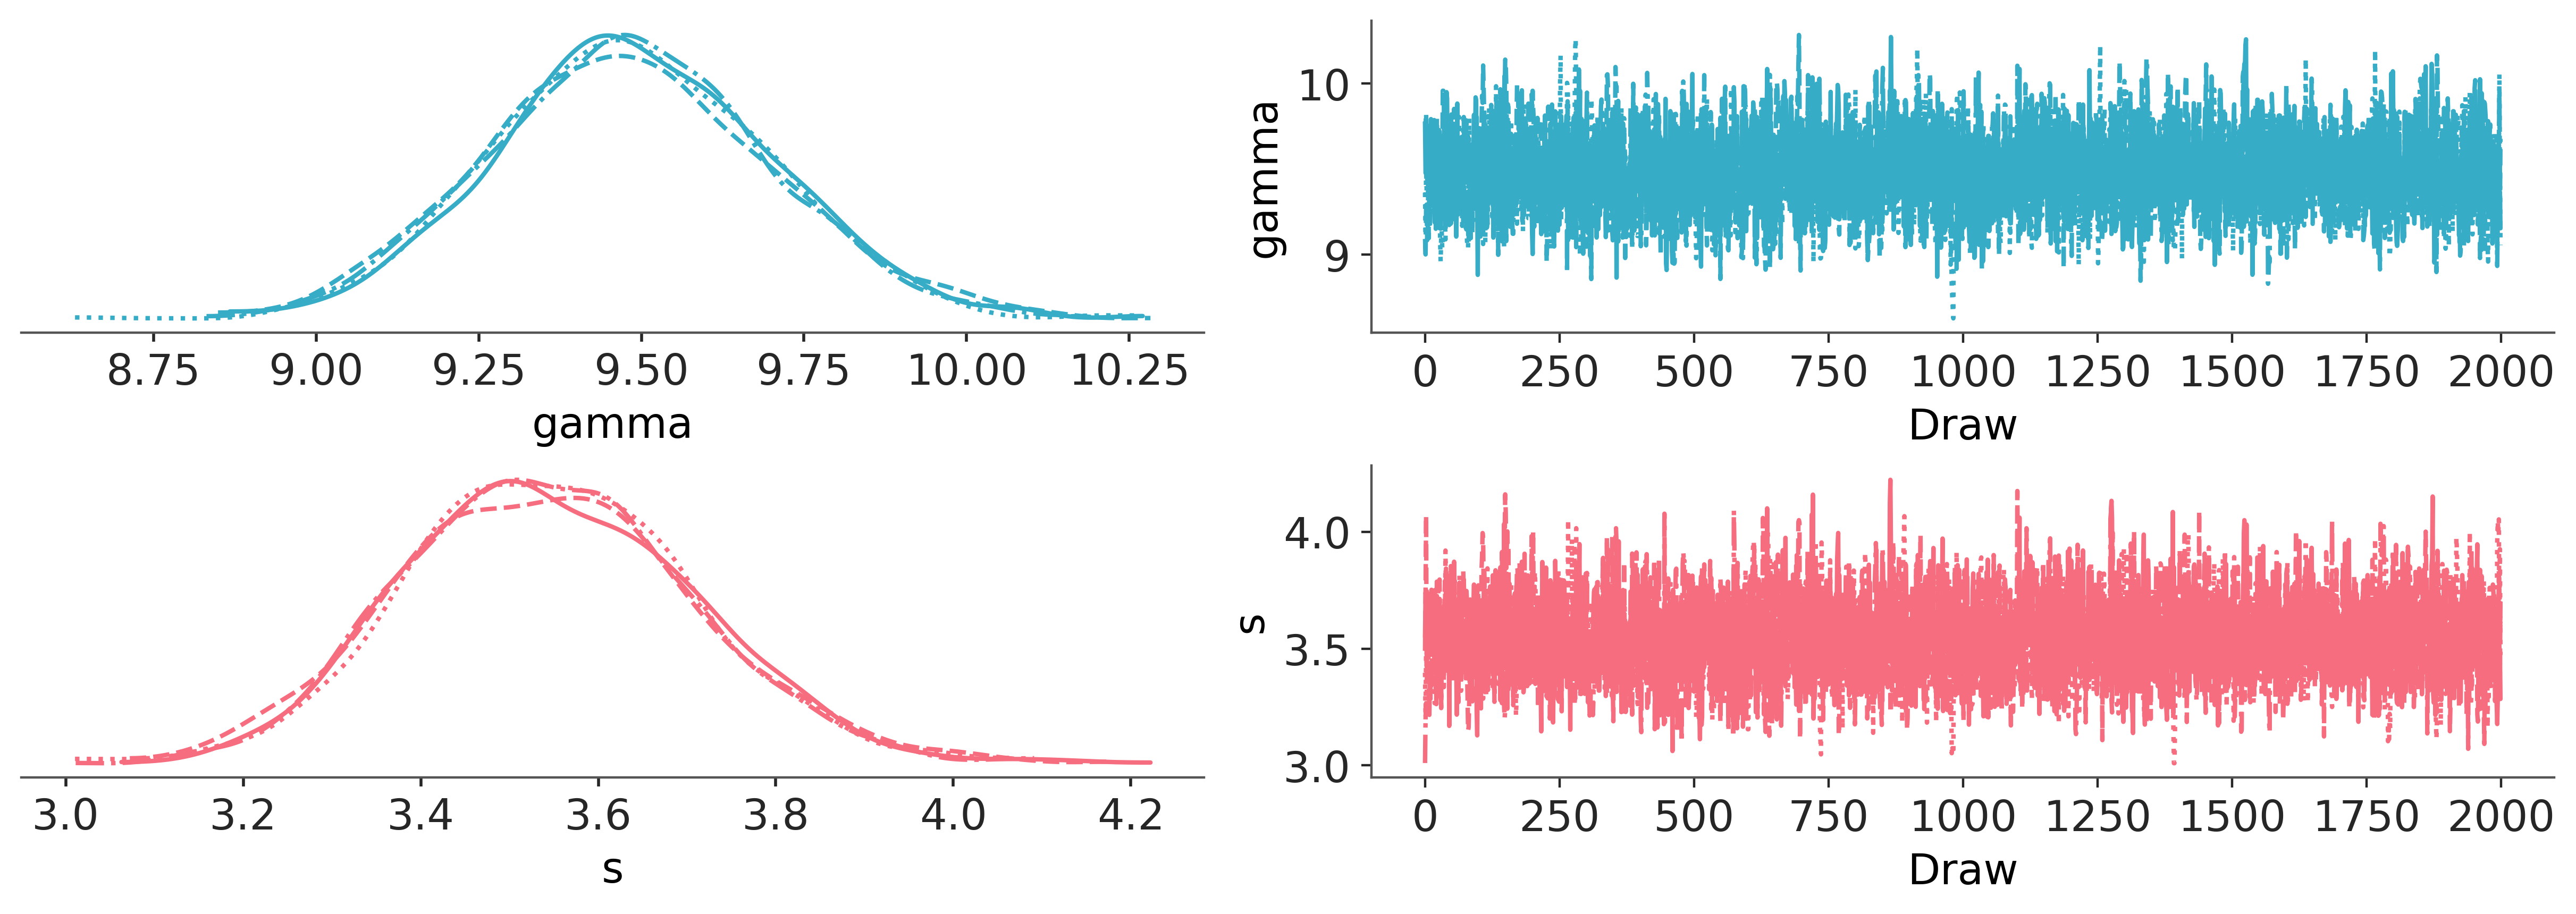

In [22]:
az.plot_trace_dist(idata_param3)

In [23]:
az.summary(idata_param3, round_to=2)

,mean,sd,eti89_lb,eti89_ub,ess_bulk,ess_tail,r_hat,mcse_mean,mcse_sd
gamma,9.48,0.21,9.15,9.83,3407.75,4062.17,1.0,0.0,0.0
s,3.54,0.16,3.30,3.81,3455.20,4259.99,1.0,0.0,0.0


## Authors

- Originally collated by [Junpeng Lao](https://junpenglao.xyz/) on Apr 21, 2018. See original code [here](https://github.com/junpenglao/Planet_Sakaar_Data_Science/blob/65447fdb431c78b15fbeaef51b8c059f46c9e8d6/PyMC3QnA/discourse_1107.ipynb).
- Authored and ported to Jupyter notebook by [George Ho](https://eigenfoo.xyz/) on Jul 15, 2018.
- Updated for compatibility with PyMC v5 by Chris Fonnesbeck on Jan 16, 2023.
- Updated to replace `pm.Potential` with `pm.Censored` by Jonathan Dekermanjian on Nov 25, 2024.

In [24]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Thu, 19 Feb 2026

Python implementation: CPython
Python version       : 3.14.3
IPython version      : 9.10.0

arviz      : 0.23.4
numpy      : 2.3.5
pymc       : 5.27.1
pytensor   : 2.37.0
statsmodels: 0.14.6

Watermark: 2.6.0



:::{include} ../page_footer.md
:::